In [1]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Sun Mar 19 13:22:00 2017
@author: cli
"""

import numpy as np
import numpy.random as npr
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from functools import reduce

class sample_GMM():
    """ Toy dataset containing points sampled from a gaussian mixture distribution.
    The dataset contains 3 sources:
    * samples
    * labels
    * densities
    """
    def __init__(self,
                 num_examples,
                 means=None,
                 variances=None,
                 priors=None,
                 **kwargs):
        rng = kwargs.pop('rng', None)
        if rng is None:
            seed = kwargs.pop('seed', 0)
            rng = np.random.RandomState(seed)

        gaussian_mixture = GMM_distribution(means=means,
                                            variances=variances,
                                            priors=priors,
                                            rng=rng)
        self.means = gaussian_mixture.means
        self.variances = gaussian_mixture.variances
        self.priors = gaussian_mixture.priors

        features, labels = gaussian_mixture.sample(nsamples=num_examples)
        densities = gaussian_mixture.pdf(x=features)

        data = {'samples': features, 'labels': labels, 'density': densities}

        self.data = data

In [2]:
import os
import glob
import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import time
import PIL
import imageio

from IPython import display

import tensorflow as tf
from tensorflow.keras import datasets, layers, Sequential, Model
from tensorflow.keras import metrics
from tensorflow.keras import constraints

tf.__version__

'2.0.0'

In [3]:
# Set environment variables
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['NCCL_TOPOLOGY'] = 'CUBEMESH'

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

# Data

In [5]:
num_disc = 10
target_size = 5000

## load GMM data

In [6]:
with open('gmm_data.pkl', 'rb') as f:
    GMM_dataset = pickle.load(f)

In [7]:
GMM_dataset.data['samples'].shape, GMM_dataset.data['labels'].shape, GMM_dataset.data['density'].shape

((10000, 2), (10000,), (10000,))

In [8]:
train_dataset = GMM_dataset.data['samples'][:target_size].astype('float32')
train_labels = GMM_dataset.data['labels'][:target_size].astype('float32')

test_dataset = GMM_dataset.data['samples'][target_size:].astype('float32')
test_labels = GMM_dataset.data['labels'][target_size:].astype('float32')

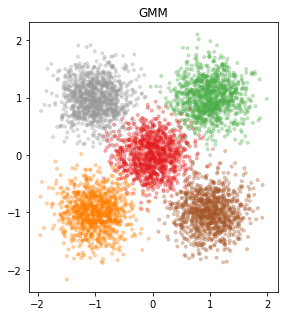

In [9]:
figure, axes = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax = axes
ax.set_aspect('equal')
ax.axis('on')
ax.set_title('GMM')

# x = dataset.data['samples']
# targets = dataset.data['labels']

axes.scatter(train_dataset[:, 0],
             train_dataset[:, 1],
             marker='.',
             c=cm.Set1(train_labels.astype(float) / 2.0 / 2.0),
             alpha=0.3)
plt.tight_layout()
#     plt.savefig(save_path, transparent=True, bbox_inches='tight')
plt.show()

## split to target and shadow

In [10]:
def EvenlySplitting(dataset, size=5):
    chunk_size = dataset.shape[0]//size
    
    splitted_datasets = []
    for i in range(size):
        temp_data = dataset[i*chunk_size:(i+1)*chunk_size]
        splitted_datasets.append(temp_data)
        
    return splitted_datasets

In [11]:
target_partions = EvenlySplitting(train_dataset, size=num_disc)

In [12]:
len(target_partions)

10

In [13]:
target_partions[0].shape

(500, 2)

# Build GAN

In [14]:
noise_dim = 2
nrow = train_dataset.shape[1]
# ncol = train_dataset.shape[2]
# channels = train_dataset.shape[3]
# input_shape = (nrow, ncol, channels)

## Generator

In [15]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(256, input_shape=(2, )))
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(2))
    assert model.output_shape == (None, 2)  # Note: None is the batch size

    return model

In [16]:
generator = make_generator_model()

noise = tf.random.normal([1, 2])
generated_sample = generator(noise, training=False)
generated_sample

# plt.imshow(generated_image[0, :, :, 0], cmap='gray')

<tf.Tensor: id=115, shape=(1, 2), dtype=float32, numpy=array([[ 0.11443976, -0.13753681]], dtype=float32)>

## Discriminator

In [17]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(256, input_shape=(2, )))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
#     model.add(layers.Dropout(0.3))
    
#     model.add(layers.Dense(256))
#     model.add(layers.LeakyReLU())
#     model.add(layers.BatchNormalization())
#     model.add(layers.Dropout())
    
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

In [18]:
# Use the (as yet untrained) discriminator 
# to classify the generated images as real or fake.
discriminators = []
for i in range(num_disc):
    discriminators.append(make_discriminator_model())

In [19]:
# check output, two outputs are different, which means discriminators are independent.
for i in range(num_disc):
    disc_output = discriminators[i](generated_sample, training=False)
    print (disc_output)

tf.Tensor([[0.5036151]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.50348544]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.49205634]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.49832726]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.5004097]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.4967601]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.5012796]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.4939951]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.50548196]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.5003001]], shape=(1, 1), dtype=float32)


## Loss

In [20]:
# cross_entropy_loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss

    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

## Optimizer

In [21]:
# Adam
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer=tf.keras.optimizers.Adam(1e-4)
# generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.999)
# discriminator_optimizer=tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.999)

# Training

In [22]:
# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
num_examples_to_generate = 1000
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [23]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig, axes= plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
    axes.set_xlim(-2, 2)
    axes.set_ylim(-2, 2)
    axes.set_aspect('equal')
    axes.axis('on')
    axes.set_title('generated_GMM-epoch{}'.format(epoch))
    
    axes.scatter(predictions[:, 0],
                 predictions[:, 1],
                 marker='.',
#                  c=cm.Set1(targets.astype(float) / 2.0 / 2.0),
                 alpha=0.3)
    plt.tight_layout()
    # plt.savefig('images/LOGAN-image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

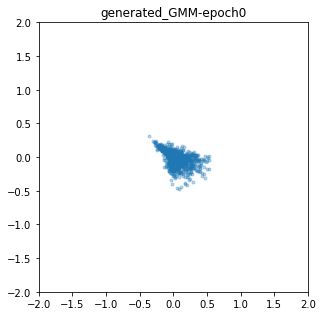

In [24]:
generate_and_save_images(generator, 0, seed)

In [25]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(batch_size, zipped_real_samples):
    # update D
    for _ in range(2):
        all_disc_loss = []
        # for each discriminator
        for i in range(num_disc):            
            noise = tf.random.normal([batch_size, noise_dim])
            with tf.GradientTape() as disc_tape:            
                generated_samples = generator(noise, training=True)
                real_output = discriminators[i](zipped_real_samples[i], training=True)
                fake_output = discriminators[i](generated_samples, training=True)

                disc_loss = discriminator_loss(real_output, fake_output)

                gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminators[i].trainable_variables)
                discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, 
                                                            discriminators[i].trainable_variables))
            all_disc_loss.append(disc_loss)
    
    # update G
    for _ in range(1):
        with tf.GradientTape() as gen_tape:
            all_gen_loss = []
            for i in range(num_disc):
                noise = tf.random.normal([batch_size, noise_dim])
                generated_samples = generator(noise, training=True)
                fake_output = discriminators[i](generated_samples, training=True)        
                gen_loss = generator_loss(fake_output)
                
                all_gen_loss.append(gen_loss)
        
            avg_gen_loss = tf.reduce_mean(all_gen_loss)
            gradients_of_generator = gen_tape.gradient(avg_gen_loss, generator.trainable_variables)
            generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))   
              
    return avg_gen_loss, all_disc_loss

In [26]:
def train(train_datasets, epochs, batch_size):
    # Batch and shuffle all datasets
    train_batches = []
    for i in range(num_disc):
        train_batches.append(
            tf.data.Dataset.from_tensor_slices(train_datasets[i]).shuffle(
                train_datasets[i].shape[0]).batch(batch_size,
                                                  drop_remainder=True))

    gen_loss_log, disc_loss_log = [], []
    for epoch in range(epochs):
        start = time.time()

        for zipped_real_samples in zip(*train_batches):
            gen_loss, all_disc_loss = train_step(batch_size, zipped_real_samples)
        # append loss of last batch
        gen_loss_log.append(gen_loss.numpy())
        disc_loss_log.append(all_disc_loss)
        
        if (epoch + 1) % 100 == 0:
            # Produce images for the GIF
            display.clear_output(wait=True)
            generate_and_save_images(generator, epoch + 1, seed)
 
        # Save the model
#         if (epoch + 1) % 500 == 0:
#             checkpoint.save(file_prefix=checkpoint_prefix)

        # print loss of last batch
        print('Epoch {}, gen_loss: {:.5f}, disc_loss: {}. Time: {:.2f} sec'.format(epoch + 1,
            gen_loss.numpy(), [loss.numpy() for loss in all_disc_loss], time.time() - start))      

    return gen_loss_log, disc_loss_log

In [27]:
checkpoint_dir = './training_checkpoints/PAR-DCGAN-{}-Disc-{}'.format(target_size, num_disc)
checkpoint_prefix = os.path.join(checkpoint_dir, "random")
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator0=discriminators[0],
    discriminator1=discriminators[1],
    discriminator2=discriminators[2],
    discriminator3=discriminators[3],
    discriminator4=discriminators[4],
    discriminator5=discriminators[5],
    discriminator6=discriminators[6],
    discriminator7=discriminators[7],
    discriminator8=discriminators[8],
    discriminator9=discriminators[9])

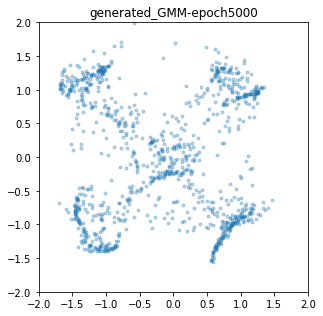

Epoch 5000, gen_loss: 0.67982, disc_loss: [1.40478, 1.3473288, 1.3856795, 1.3738022, 1.3214923, 1.3849546, 1.3774476, 1.3999271, 1.4025933, 1.3826631]. Time: 0.71 sec


In [28]:
EPOCHS = 5000
BATCH_SIZE = 32
gen_loss_log, disc_loss_log = train(target_partions,
                                    epochs=EPOCHS,
                                    batch_size=BATCH_SIZE)

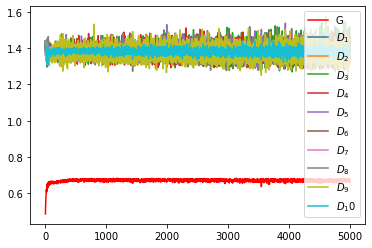

In [29]:
# loss curve
# generator
plt.plot(range(len(gen_loss_log)), gen_loss_log, 'r', label='G')

# discriminator
disc_loss_array = np.asarray(disc_loss_log)
for i in range(num_disc):
    plt.plot(range(disc_loss_array.shape[0]), disc_loss_array[:,i], label='$D_{}$'.format(i+1))

plt.legend()
plt.show()

## Check storing point

In [30]:
# load checkpoint
storing_point = tf.train.latest_checkpoint(checkpoint_dir)
print(storing_point)
# checkpoint.restore(storing_point)

./training_checkpoints/PAR-DCGAN-5000-Disc-10/smallerD-10


# Quatitative evaluation 

In [31]:
noise = tf.random.normal([target_size//5, noise_dim])
generated_samples = generator(noise, training=False)

In [32]:
generated_samples.shape

TensorShape([1000, 2])

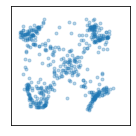

In [33]:
figure, axes = plt.subplots(nrows=1, ncols=1, figsize=(2, 2))

axes.xaxis.set_visible(False)
axes.yaxis.set_visible(False)
# plt.title('DCGAN')
axes.scatter(generated_samples[:500, 0],
             generated_samples[:500, 1],
             marker='.',
#              c=cm.Set1(train_labels.astype(float) / 2.0 / 2.0),
             alpha=0.3)
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.tight_layout()
# plt.savefig('plot_figures/blob-par-DCGAN-Size500-Disc10.pdf', format='pdf')
plt.show()

## FID

In [34]:
import os
from numpy import cov, trace, iscomplexobj, asarray
from numpy.random import randint
from scipy.linalg import sqrtm
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

from skimage.transform import resize
from sklearn import metrics as sklearn_metrics

# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return asarray(images_list)

# calculate frechet inception distance
def calculate_fid(model, images1, images2):
    # calculate activations
    act1 = model.predict(images1)
    act2 = model.predict(images2)
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [35]:
# prepare the inception v3 model
model = InceptionV3(include_top=False,
                    pooling='avg',
                    input_shape=(299, 299, 3))

In [36]:
# convert integer to floating point values
images1 = test_dataset.astype('float32')
images2 = generated_samples.numpy().astype('float32')

# resize images
images1 = scale_images(images1, (299, 299, 3))
images2 = scale_images(images2, (299, 299, 3))
print('Scaled', images1.shape, images2.shape)

Scaled (5000, 299, 299, 3) (1000, 299, 299, 3)


In [37]:
# pre-process images
images1 = preprocess_input(images1)
images2 = preprocess_input(images2)
# fid between images1 and images1
# fid = calculate_fid(model, images1, images1)
# print('FID (same): %.3f' % fid)
# fid between images1 and images2
fid = calculate_fid(model, images1, images2)
print('FID (different): %.3f' % fid)

FID (different): 0.109
